In [2]:
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

import matplotlib.pyplot as plt
import numpy as np

<center>
<h2>Logistic Regression<br>and Conditional Random Fields</h2>
<p style="text-align:center">
Natural Language Processing<br>
(COM4513/6513)<br>
<br>
<a href="http://andreasvlachos.github.io">Andreas Vlachos</a><br>
a.vlachos@sheffield.ac.uk<br>
<small>Department of Computer Science<br>
University of Sheffield
</small>
</p>
</center>

### Sequence labeling

Parts of speech (PoS):

| The       | results  | appear | in          | today| 's         |news |
| --------- |----------| -------| ------------|----- |------------|-----|
| determiner       | noun     | verb   | preposition | noun | possesssive| noun|

Other tasks?

Named entity recognition

| I       | studied  | in | Sheffield  | with| Mark   |Stevenson |
| ------- |----------| ---| -----------|-----|--------|-----|
| O       | O        | O  | B-Location | O   |B-Person| I-Person|

**B**egin, **I**nside, **O**utside named entity type: Person, Location, Organization, etc.

### Hidden Markov Models

<a href="http://www.slideshare.net/priberam/introducing-priberam-labs-machine-learning-and-natural-language-processing"><img width="500" src="images/hmm_pos_crop.png"></a>

$\mathbf{\hat y} = \mathop{\arg \max}\limits_{\mathbf{y} \in \cal Y^N} \prod_{n=1}^NP(x_n|y_n)P(y_n|y_{n-1})$

- 1st order Markov assumption on the tags
- each word depends only on its tag
- Don't evaluate $|{\cal Y}^N|$, use Viterbi

### Structured perceptron

A giant linear classifier over $\mathbf{y} \in \cal Y^N$:

$$\mathbf{\hat y} = \mathop{\arg \max}\limits_{\mathbf{y} \in \cal Y^N} \mathbf{w} \cdot \Phi(\mathbf{x},\mathbf{y})$$

$\Phi$ generates features capturing the compatibility between sentence $\mathbf{x}$ and tag sequence $\mathbf{y}$

- Any features we want
- Exact search with Viterbi if 1st Markov assumption
- Inexact search with beam search for feature flexibility

### In this lecture

Hidden Markov models are very useful, but:
- generate words and labels, we only want labels
- no overlapping features (e.g. no word bigrams)

Structured perceptron has feature flexibility, but no probabilities.

Conditional models address this. Three steps: 
1. Logistic regression classifier
2. Gradient-based optimization
3. Conditional Random Fields


### Binary linear classification setup

Given training instances with the correct labels $y^m \in \{-1,1\}$

$$D_{train} = \{\mathbf{x}^1,y^1)...(\mathbf{x}^M,y^M)\}$$

Find the weights $\mathbf{w}$ for the linear classifier

$$\hat y = sign(\sum_{n=1}^N w_nx_n) = sign(\mathbf{w} \cdot \mathbf{x})$$

so that we can predict the labels of **unseen** documents


### From scores to probabilities

score for the positive class:
$$score_{perc}(\mathbf{x};\mathbf{w}) = \mathbf{w} \cdot \mathbf{x}$$

probability for the positive class:
$$P(y=1|\mathbf{x};\mathbf{w}) = sigmoid(\mathbf{w} \cdot \mathbf{x}) =  \frac{1}{1+exp(-\mathbf{w} \cdot \mathbf{x})} $$

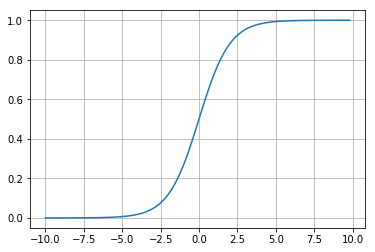

In [4]:
x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.grid()
plt.show()

### From binary to multiclass

Binary logistic regression using feature function $\phi$:
$$P_{BLR}(y=1|x;\mathbf{w}) = \frac{1}{1+exp(-\mathbf{w} \cdot \phi(x))} $$

Multiclass logistic regression (weights on compatibility features):

$$P_{MLR}(y=\hat y|x;\mathbf{w}) = \frac{\exp(\mathbf{w} \cdot \phi(x,\hat y))}{\sum_{y'\in \cal Y}\exp(\mathbf{w} \cdot \phi(x,y'))} $$

or equivalently (weights per class):

$$P_{MLR}(y=\hat y|x;\mathbf{w}) = \frac{\exp(\mathbf{w}^{\hat y} \cdot \phi(x))}{\sum_{y'\in \cal Y}\exp(\mathbf{w}^{y'} \cdot \phi(x))} $$


### Logistic regression vs perceptron classification

Questions:
- same feature flexibility?
- given the same $\textbf{w}$, same decision $\hat y$?
- same interpretation of scores?

Answers:
- Yes: same $\phi$ definition
- Yes: $\mathop{\arg \max}\limits_{\hat y \in \cal Y} P_{MLR}(y=\hat y|x,\mathbf{w}) = \mathop{\arg \max}\limits_{y \in \cal Y} score_{perc}(x;\mathbf{w}^{\hat y})$
- No: a score in the perceptron is just bigger than another score

### Training

What $\mathbf{w}$ best fits $D_{train} = \{(x_1,y_1)... (x_N, y_N)\}$?

The $\mathbf{w}^{\star} \in \cal \Re^d$ ($d=$ number of features) maximizing log-likelihood:

$$\mathbf{w}^{\star} = \mathop{\arg \max}\limits_{\mathbf{w}} L(\mathbf{w};D_{train}) = \mathop{\arg \max}\limits_{\mathbf{w}} \sum_{n=1}^N \log P_{LR}(y_n|x_n;\mathbf{w})$$

Not enough to avoid mistakes, make them unlikely!

### Numerical Optimization

is the research field that studies how to max/min-imize the value of a function $f(x)$ by changing $x$.

In our case (and a lot of supervised machine learning):

$$\mathbf{w}^{\star} = \mathop{\arg \max}\limits_{\mathbf{w}} LogLikelihood(\mathbf{w};D_{train})$$

Binary logistic regression has one parameter per features, many parameters!

Let's look at a simpler case:
$$x^\star = \mathop{\arg \max}\limits_{x \in \Re} f(x), f(x)=x^2$$

### Random optimization

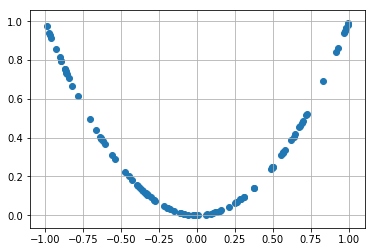

In [10]:
x = np.random.uniform(low=-1.0, high=1.0, size=100) 
y = np.square(x)
plt.scatter(x,y)
plt.grid()
plt.show()

Works if try many parameter values and evaluate them! 

With many parameters and their combination not so useful.

### Gradient-based optimization

How can we use the knowledge that $f(x)=x^2$ in selecting points?

Gradient of the function f w.r.t to parameter x:
$$\nabla _x f(x) $$
When evaluated at $x_k$:
- $sign(\nabla _x f(x))$ tells us if by increasing x, f(x) will increase (+) or decrease (-)
- $|\nabla _x f(x)|$ tells us how fast the in/de-crease will be

What does it mean if the gradient at $x_k$ is 0?

### Gradient-based optimization

<a href="http://bestmaths.net/online/index.php/year-levels/year-12/year-12-topic-list/first-principles/"><img src="images/Y12_Differentiation_from_First_Principles_02.gif"></a>

$f(x)=x^2$

$\nabla_x f(x) = 2x$

$f(x)$ is convex, thus if $\nabla_x f(x_k) = 0$ then $x_k = \mathop{\arg \max}\limits_{x \in \Re} f(x)$

### Gradient descent
<p style="border:3px; width:1000px; border-radius: 25px; background-color:lightgrey; border-style:solid; border-color:black; padding: 0.3em;">
\begin{align}
& \textbf{Input:} \; D_{train} = \{(x_1,y_1)...(x_N,y_N)\}, learning \; rate\; \alpha\\
& initialize\; \mathbf{w} \\
& \mathbf{while} \; not \; converged \; \mathbf{do}\\
& \quad update \; \mathbf{w} = \mathbf{w} - \alpha \nabla_{\mathbf{w}} NLL(\mathbf{w};D_{train}) \\
& \mathbf{return} \; \mathbf{w}
\end{align}
</p>

- minimizing the negative log likelihood ($NLL$) = maximize the likelihood
- learning rate shouldn't be too big; more advanced methods adapt it

### Gradient meaning

The gradient wrt to the parameter vector $\mathbf{w} \in \Re^d$ is decomposed into the partial derivatives wrt to each parameter $w_k$:

$$\nabla_{\mathbf{w}} LL(\mathbf{w};D_{train}) = (\frac{\partial \sum_{n=1}^N \log P(y_n|x_n;\mathbf{w})}{\partial w_1}, \ldots, \frac{\partial \sum_{n=1}^N \log P(y_n|x_n;\mathbf{w})}{\partial w_d})$$

\begin{align}
\frac{\partial LL(\mathbf{w};D_{train})}{\partial w_d} &= \frac{\partial \sum_{n=1}^N \log P(y_n|x_n;\mathbf{w})}{\partial w_d}\\
&= ...\\
&= \sum_{n=1}^N \phi_d(x_n,y_n) \quad \text{feature sum in training data}  \\
&- \sum_{n=1}^N \sum_{y \in \cal Y} P(y|x_n;\mathbf{w})\phi_d(x_n,y) \quad \text{its expectation}
\end{align}

### Regularization

Any model with a lot of features is prone to **overfitting** its training data: high training accuracy, low test accuracy.

Avoid it by adding a regularizer in the objective:

$$L_{reg}(\mathbf{w};D_{train}) = L(\mathbf{w};D_{train}) + \lambda R(\mathbf{w})$$

If $ R(\mathbf{w}) = \sum_{k=1}^Kw_k^2$ ($L_2$-regularization) then:

$$\frac{\partial L_{reg}(\mathbf{w};D_{train})}{\partial w_k} = \frac{\partial L(\mathbf{w};D_{train})}{\partial w_k} - 2\lambda w_k$$

Intuitively: prefer small parameter values, by not updating as much.

### Sequence labeling setup

Training data is word sequences with label sequences:

\begin{align}
D_{train} & = \{(\mathbf{x}^1,\mathbf{y}^1)...(\mathbf{x}^M,\mathbf{y}^M)\} \\
\mathbf{x}^m & = [x_1,... x_N]\\
\mathbf{y}^m & = [y_1,... y_N]
\end{align}

for example:
\begin{align}
(\mathbf{x},\mathbf{y})=(&[I,studied,in,Sheffield],\\
&[Pronoun,Verb,Preposition,ProperNoun])
\end{align}

### Conditional random fields

The [paper](http://cs.utsa.edu/~qitian/seminar/Spring11/02_11_11/ICML2001.pdf) from 2001 has >11K citations and has won the [10 year test of time award](https://www.ml.cmu.edu/news/news-archive/2011-2015/2011/june/icml-test-time-award-2011.html)

A giant logistic regression classifier over sequences:

$$P_{CRF}(\mathbf{y}|\mathbf{x};\mathbf{w}) =  \frac{\exp(\mathbf{w} \cdot \Phi(\mathbf{x},\mathbf{y}))}{\sum_{\mathbf{y'}\in \cal Y^N}\exp(\mathbf{w} \cdot \Phi(\mathbf{x},\mathbf{y'}))} $$


For linear chain (1st order Markov) CRFs:
$$\Phi(\mathbf{x},\mathbf{y}) = \sum_{n=1}^N \phi(y_n, y_{n-1}, \mathbf{x}, n)$$

Just going from perceptron to structured perceptron?

### Conditional random fields

Inference with Viterbi, normalization factor is ignored:

$$ \mathop{\arg \max}\limits_{\mathbf{y} \in \cal Y^N} P_{CRF}(\mathbf{y}|\mathbf{x};\mathbf{w}) =  \mathop{\arg \max}\limits_{\mathbf{y} \in \cal Y^N} \sum_{n=1}^N \mathbf{w} \cdot \phi(y_n, y_{n-1}, \mathbf{x}, n) $$

Training by maximizing the log-likelihood objective:

$$\mathbf{w} = \mathop{\arg \max}\limits_{\mathbf{w} \in \cal \Re^d} \sum_{m=1}^M \log P_{CRF}(\mathbf{y^m}|\mathbf{x^m};\mathbf{w})$$

- The normalization factor has to score all possible label sequences for all sentences, expensive even with Viterbi!
- Maximize the objective one sentence at a time, a.k.a. **stochastic gradient descent**

### From Naive Bayes to Structured Perceptron

<a href="http://kaizhao.me/files/perc-tutorial-masc.pdf"><img src="images/binary_to_struct_perceptron.jpg"></a>

### Bibliography

- Michael Collins's [notes](http://www.cs.columbia.edu/~mcollins/crf.pdf)
- This [blog post](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/) by Edwin Chen
- Xavier Carreras's [lecture slides](http://lxmls.it.pt/2016/strlearn.pdf)
- Everything you ever wanted to know about CRFs is in Sutton and McCallum's [tutorial](http://homepages.inf.ed.ac.uk/csutton/publications/crftut-fnt.pdf)

### Coming up next

The best-studied, more complex than sequence labeling problem in NLP, syntactic parsing.